In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import child_poverty_iraq.data.load_data as ld
import child_poverty_iraq.utils.constants as c

In [2]:
mosaiks_adm1 = ld.get_mosaiks_adm1()
pov_adm1 = ld.get_poverty_adm1()

Mosaiks shape: (2849, 4001)
The file '../data/external/geoBoundariesCGAZ_ADM1.topojson' exists.
Geometry shape: (3291, 9)
(2849, 4010)
Number of obs with missing geometry: 1
(2848, 4010)
Poverty shape: (1110, 13)


100%|██████████| 176/176 [00:35<00:00,  4.98it/s]

Geometry shape: (2554, 5)
Poverty + geometry shape: (1110, 18)


In [3]:
merged = ld.merge_mosaiks_pov_adm1(pov_adm1, mosaiks_adm1, threshold=0.51)

(6813, 4030)
(1033, 4034)


The file '../data/interim/IRQ_mosaiks_ADM2.csv' exists.


(101, 4002)
(101, 2)
(101, 4003)


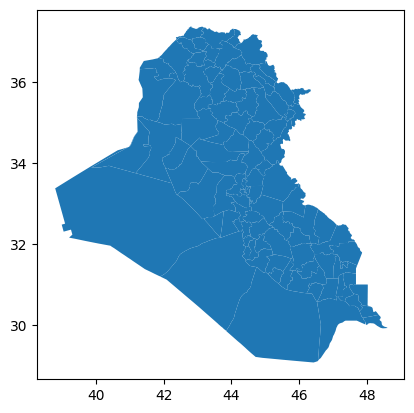

In [4]:
irq_adm2 = ld.adm2_for_country(cc='IRQ')

# EDA

Text(0.5, 1.0, 'ADM1 Moderate Prevalence')

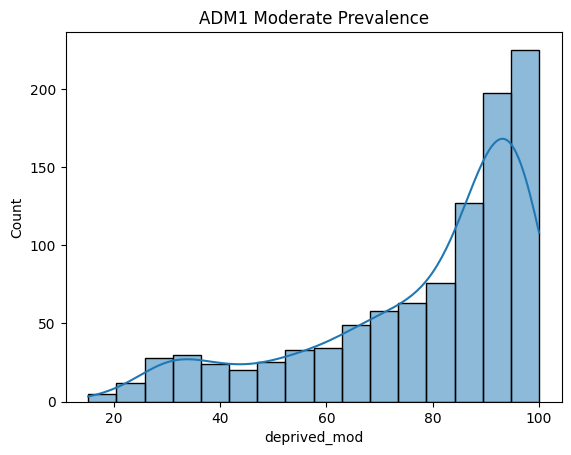

In [7]:
sns.histplot(merged['deprived_mod'], kde=True)
plt.title('ADM1 Moderate Prevalence')

In [10]:
# # Demean approach
# merged['deprived_mod_demean'] = merged['deprived_mod'] - merged['nat_deprived_mod']
# merged['deprived_mod_demean'].hist()

Text(0.5, 1.0, 'Logarithm')

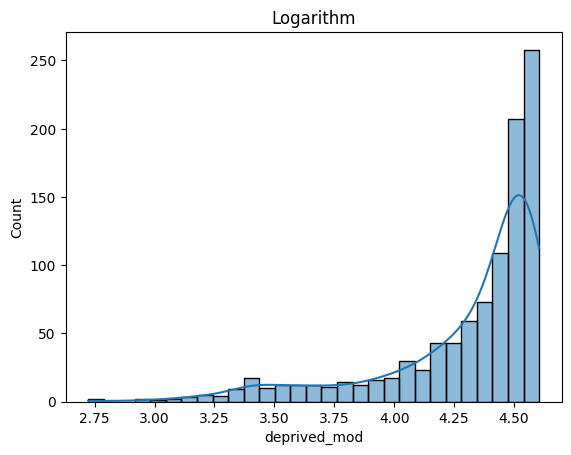

In [7]:
sns.histplot(np.log(merged['deprived_mod']), kde=True)
plt.title('Logarithm')

Text(0.5, 1.0, 'Square root')

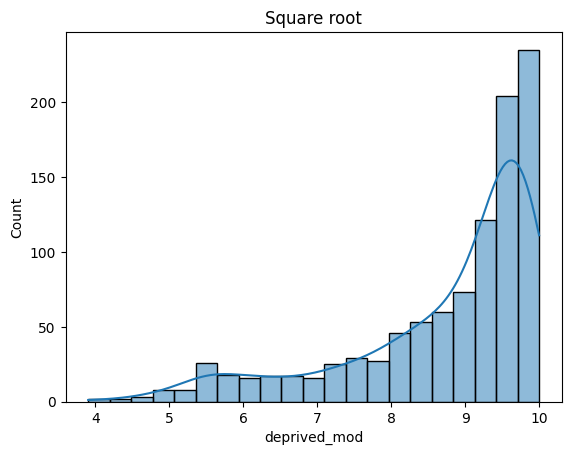

In [8]:
sns.histplot(np.sqrt(merged['deprived_mod']), kde=True)
plt.title('Square root')

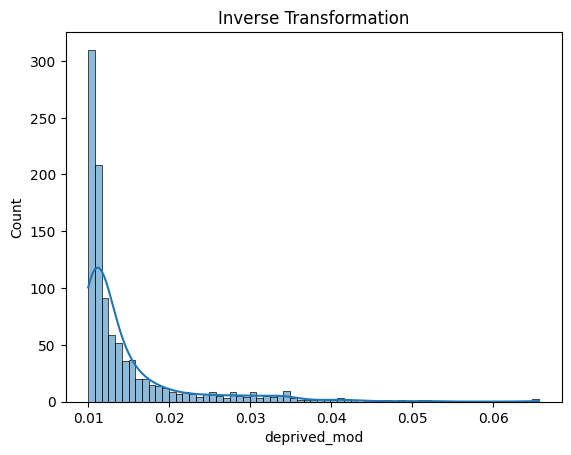

In [12]:
# Inverse transformation
inverse_transformed = 1 / merged['deprived_mod']

# Plot the transformed data
sns.histplot(inverse_transformed, kde=True)
plt.title("Inverse Transformation")
plt.show()

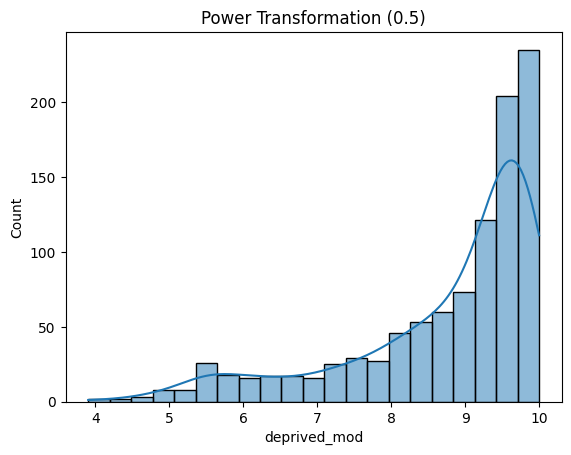

In [13]:
# Power transformation (raising to the power of 0.5)
power_transformed = np.power(merged['deprived_mod'], 0.5)

# Plot the transformed data
sns.histplot(power_transformed, kde=True)
plt.title("Power Transformation (0.5)")
plt.show()

# Boxcox

In [10]:
target = 'deprived_mod'
print(merged[target].isna().sum())

tmp = merged[merged[target].isna()==False].copy()
print(tmp.shape)

27
(1006, 4034)


Lambda: 2.69351856995555


<Axes: ylabel='Count'>

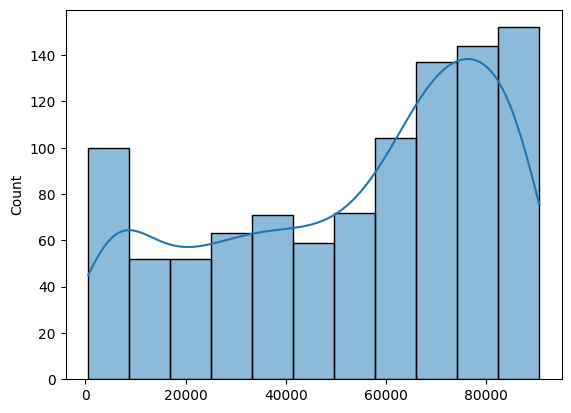

In [18]:
from scipy import stats

# Box-Cox transformation
boxcox_transformed, lmbda = stats.boxcox(tmp['deprived_mod'])
print(f'Lambda: {lmbda}')

tmp['deprived_mod_bc'] = boxcox_transformed

# Plot the transformed data
sns.histplot(boxcox_transformed, kde=True)

In [22]:
import scipy


<Axes: xlabel='deprived_mod_bc', ylabel='Count'>

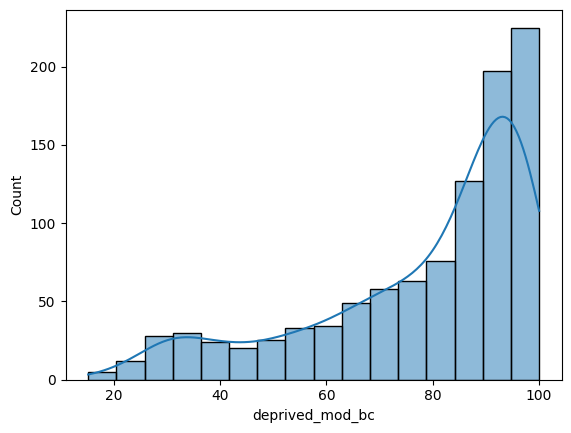

In [23]:
retransformed = scipy.special.inv_boxcox(tmp['deprived_mod_bc'], lmbda)
sns.histplot(retransformed, kde=True)

# Oversampling

In [37]:
from tqdm import tqdm

def oversample_to_uniform_distribution(df, target_column='y', num_bins=5):
    # Calculate the desired number of samples in each bin (same as the majority bin)
    hist, bin_edges = np.histogram(df[target_column], bins=num_bins)
    majority_bin_count = np.max(hist)
    bin_counts = [majority_bin_count] * num_bins

    # Create a new DataFrame to store the oversampled data
    df_augmented = pd.DataFrame(columns=df.columns)

    # Oversample each bin
    for i in tqdm(range(num_bins)):
        # Extract data points in the current bin
        bin_start, bin_end = bin_edges[i], bin_edges[i + 1]
        bin_data = df[(df[target_column] >= bin_start) & (df[target_column] < bin_end)]

        # Oversample the bin to match the majority bin count
        oversampled_bin = bin_data.sample(bin_counts[i], replace=True, random_state=42)

        # Append the oversampled data to the new DataFrame
        df_augmented = pd.concat([df_augmented, pd.DataFrame(oversampled_bin)], ignore_index=True)

    return df_augmented

In [38]:
merged_clean = merged.dropna(subset=['deprived_mod'])

np.array(merged_clean['deprived_mod']).min()

15.225185

100%|██████████| 10/10 [00:00<00:00, 10.10it/s]


(3450,)


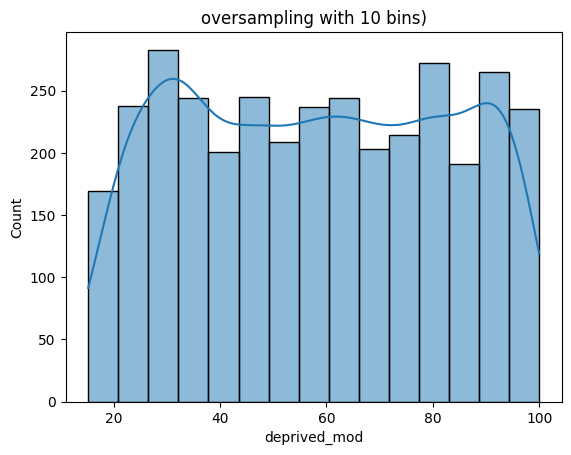

In [43]:
oversampled = oversample_to_uniform_distribution(merged_clean, target_column='deprived_mod', num_bins=10)['deprived_mod']

print(oversampled.shape)

# Plot the transformed data
sns.histplot(oversampled, kde=True)
plt.title("oversampling with 10 bins")
plt.show()

# Discretizing into Classes

In [65]:
def discretize_target(df, K, target_column='y'):
    # Create K equally spaced bin edges between the minimum and maximum values of 'y'
    bin_edges = pd.cut(df[target_column], bins=K, labels=False, include_lowest=True)
    
    # Create a new DataFrame with discretized 'y' values
    df_discrete = df.copy()
    df_discrete[target_column] = bin_edges
    
    return df_discrete


oversampled_discrete = discretize_target(oversampled, K=10, target_column='deprived_mod')

sns.histplot(oversampled_discrete, kde=True)
plt.title("oversampling with 10 bins and 10 classes")
plt.show()

KeyError: 'deprived_mod'

# Linear Regression

In [46]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
# Get country shapes
geom_adm0 = ld.get_mosaiks_geom_adm0()


The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


In [ ]:
def evaluate(model):
    

In [48]:
target = 'deprived_mod'

27
(1006, 4034)


<Axes: >

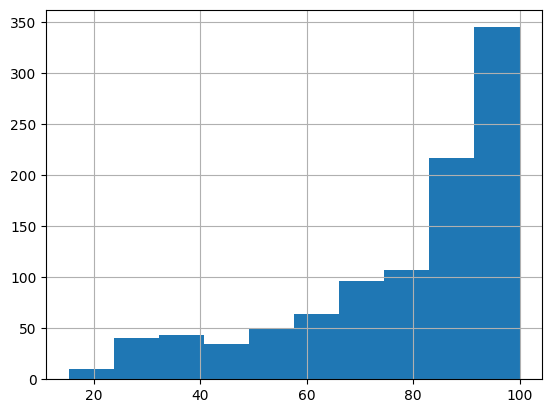

In [50]:
merged_clean[target].hist()

In [53]:
merged_train, merged_test = train_test_split(merged_clean, test_size=0.2, random_state=42)

merged_train_over = oversample_to_uniform_distribution(merged_train, target_column='deprived_mod', num_bins=10)
merged_test_over = oversample_to_uniform_distribution(merged_test, target_column='deprived_mod', num_bins=10)

X_train, y_train = merged_train_over[c.mosaiks_features], merged_train_over[target]
X_test_over, y_test_over = merged_test_over[c.mosaiks_features], merged_test_over[target]
X_test, y_test = merged_test[c.mosaiks_features], merged_test[target]

100%|██████████| 10/10 [00:00<00:00, 18.60it/s]


In [29]:
X, y = tmp[c.mosaiks_features], tmp[target]

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sum(y_train.isnull())

0

In [54]:
# Initialize the Lasso regression model
model = Lasso(alpha=0.03)  # You can adjust the alpha value (regularization strength)
# model = LinearRegression()
# model = LinearRegression()
# model = ElasticNet()
# model = SVR(C=1.0)
# model = SVR(C=0.01)

# Fit the model using K-fold cross-validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

scores = cross_val_score(model, X_train, y_train, cv=kf, scoring = 'r2')
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)

print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Fit the model to the entire training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Calculate mean squared error and R-squared on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"Training Mean Squared Error: {mse_train:.2f}")
print(f"Training R-squared: {r2_train:.2f}")
print()
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+04, tolerance: 1.309e+02
  model = cd_fast.enet_coordinate_descent(
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.874e+04, tolerance: 1.330e+02
  model = cd_fast.enet_coordinate_descent(
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

0.58 R2 with a standard deviation of 0.03


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.607e+04, tolerance: 1.649e+02
  model = cd_fast.enet_coordinate_descent(


Training Mean Squared Error: 251.44
Training R-squared: 0.58

Mean Squared Error: 368.92
R-squared: 0.09


In [52]:

# Initialize the Lasso regression model
model = Lasso(alpha=0.03)  # You can adjust the alpha value (regularization strength)
# model = LinearRegression()
# model = LinearRegression()
# model = ElasticNet()
# model = SVR(C=1.0)
# model = SVR(C=0.01)

# Fit the model using K-fold cross-validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

scores = cross_val_score(model, X_train, y_train, cv=kf, scoring = 'r2')
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)

print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Fit the model to the entire training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test_over)

# Evaluate the model's performance
mse = mean_squared_error(y_test_over, y_test_pred)
r2 = r2_score(y_test_over, y_test_pred)

# Calculate mean squared error and R-squared on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"Training Mean Squared Error: {mse_train:.2f}")
print(f"Training R-squared: {r2_train:.2f}")
print()
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+04, tolerance: 1.309e+02
  model = cd_fast.enet_coordinate_descent(
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.874e+04, tolerance: 1.330e+02
  model = cd_fast.enet_coordinate_descent(
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

0.58 R2 with a standard deviation of 0.03


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.607e+04, tolerance: 1.649e+02
  model = cd_fast.enet_coordinate_descent(


Training Mean Squared Error: 251.44
Training R-squared: 0.58

Mean Squared Error: 381.37
R-squared: 0.40


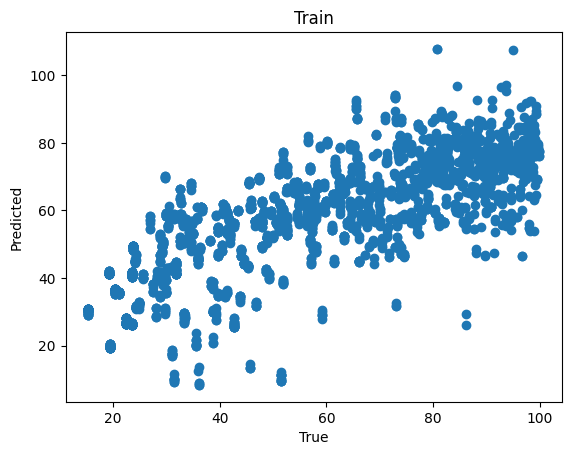

Text(0.5, 1.0, 'Test')

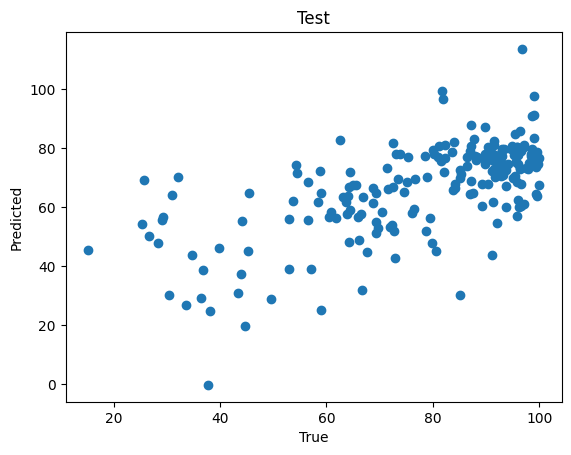

In [55]:
plt.scatter(y_train, y_train_pred)
plt.title('Train')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

plt.scatter(y_test, y_test_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Test')

In [56]:
target = 'deprived_mod'

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(array([  3.,  24.,  56.,  94., 183., 276., 274.,  75.,  18.,   3.]),
 array([-43.32308609, -33.34561122, -23.36813635, -13.39066148,
         -3.41318662,   6.56428825,  16.54176312,  26.51923798,
         36.49671285,  46.47418772,  56.45166258]),
 <BarContainer object of 10 artists>)

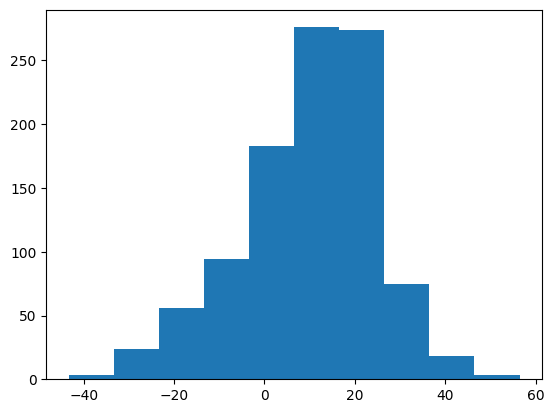

In [57]:
merged_clean['predictions'] = model.predict(merged_clean[c.mosaiks_features])
# tmp['predictions_bc'] = model.predict(tmp[c.mosaiks_features])

# tmp['predictions'] = scipy.special.inv_boxcox(tmp['predictions_bc'], lmbda)
# merged['target_error'] = merged[target]-merged['predictions']

# tmp['target_error'] = tmp[target]-tmp['predictions']
merged_clean['target_error'] = merged_clean[target]-merged_clean['predictions']

plt.hist(merged_clean['target_error'])
# plt.hist(tmp['target_error'])

In [59]:
error_max = abs(merged_clean['target_error'].max())
# error_max = abs(tmp['target_error'].max())
error_max

56.45166258312495

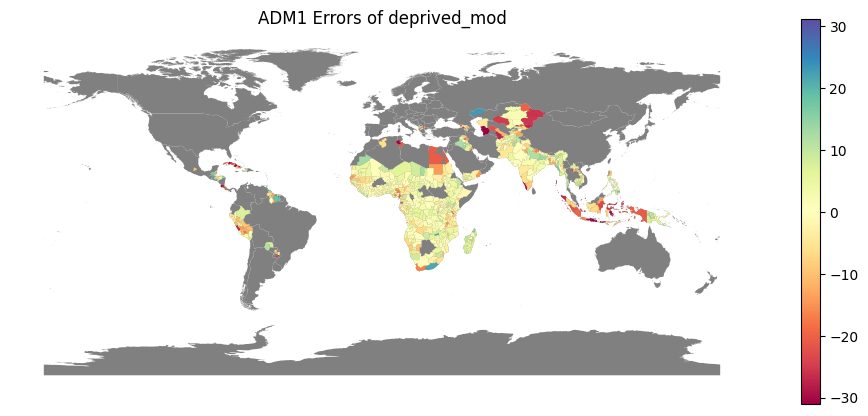

In [38]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5))

# Plot world countries
geom_adm0.plot(ax=ax, color='gray')

# Plot countries with national poverty estimates
# merged.plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)
tmp.plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)

plt.title(f'ADM1 Errors of {target}')
plt.axis('off')
plt.show()


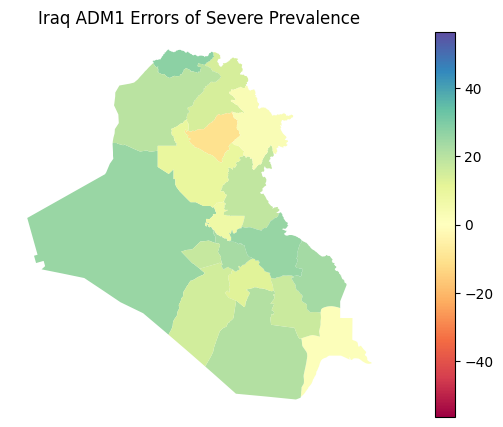

In [60]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5))

# Plot countries with ADM1 error poverty estimates
merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)
# tmp[tmp['countrycode']=='IRQ'].plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)

plt.title('Iraq ADM1 Errors of Severe Prevalence')
plt.axis('off')
plt.show()


In [32]:
# merged['predictions_remean'] = merged['predictions'] + merged['nat_deprived_mod']

In [40]:
tmp[target].max()

100.0

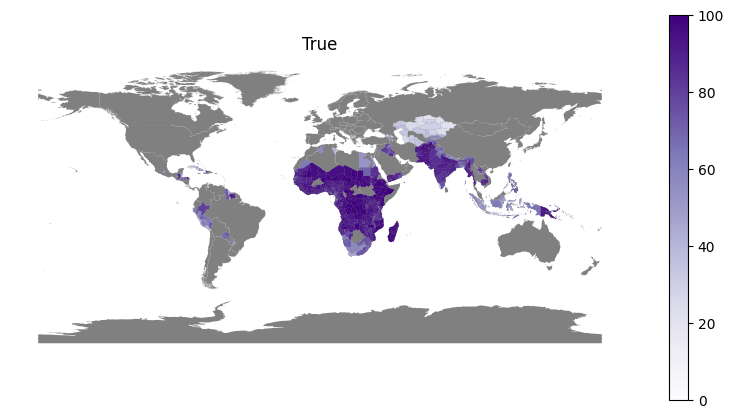

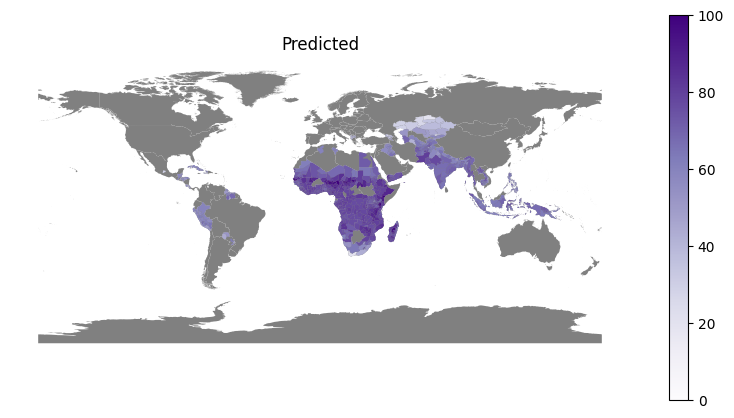

In [64]:
## Predictions vs True

# True
fig, ax = plt.subplots(figsize=(10, 5))
geom_adm0.plot(ax = ax, color='gray')
merged_clean.plot(ax = ax, column=target, cmap='Purples', legend=True, vmin=0, vmax=100)
# tmp.plot(ax = ax, column=target, cmap='Purples', legend=True, vmin = tmp[target].min(), vmax= tmp[target].max())
ax.set_title('True')
ax.axis('off')
plt.show()

# Predicted
fig, ax = plt.subplots(figsize=(10, 5))
geom_adm0.plot(ax = ax, color='gray')
merged_clean.plot(ax= ax, column='predictions', cmap='Purples', legend=True, vmin=0, vmax=100)
# tmp.plot(ax= ax, column='predictions', cmap='Purples', legend=True, vmin = tmp[target].min(), vmax= tmp[target].max())
ax.set_title('Predicted')
ax.axis('off')
plt.show()


# IRQ ADM2

In [45]:
merged[merged['countrycode']=='IRQ']['deprived_mod'].describe()

count    18.000000
mean     73.126146
std       8.231372
min      51.395329
25%      68.698382
50%      75.273170
75%      77.188135
max      86.324516
Name: deprived_mod, dtype: float64

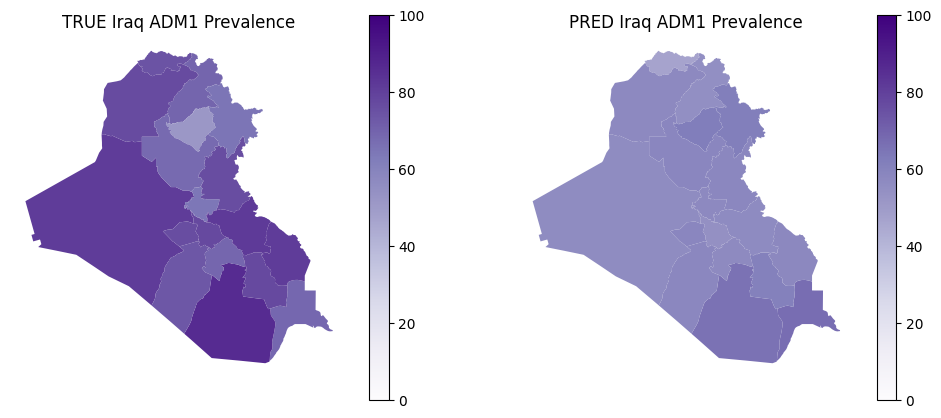

In [63]:
# Predicted
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax= ax[0], column=target, cmap='Purples', legend=True, vmin=0, vmax=100)
# tmp[tmp['countrycode']=='IRQ'].plot(ax= ax[0], column=target, cmap='Purples', legend=True, vmin = 0, vmax= 100)
ax[0].set_title('TRUE Iraq ADM1 Prevalence')
ax[0].axis('off')


merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax= ax[1], column='predictions', cmap='Purples', legend=True, vmin=0, vmax=100)
# tmp[tmp['countrycode']=='IRQ'].plot(ax= ax[1], column='predictions', cmap='Purples', legend=True, vmin = 0, vmax= 100)
ax[1].set_title('PRED Iraq ADM1 Prevalence')
ax[1].axis('off')
plt.show()

In [50]:
irq_adm2['predictions_bc'] = model.predict(irq_adm2[c.mosaiks_features])

irq_adm2['predictions'] = scipy.special.inv_boxcox(irq_adm2['predictions_bc'], lmbda)


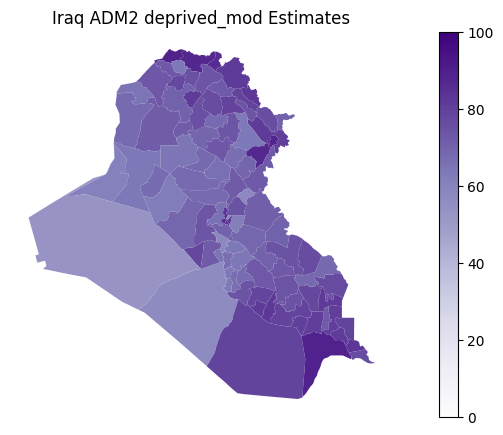

In [52]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5))

# Plot ADM2 prevalence estimate
irq_adm2.plot(ax=ax, column='predictions', cmap='Purples', legend=True, vmin = 0, vmax= 100)

plt.title(f'Iraq ADM2 {target} Estimates')
plt.axis('off')
plt.show()


In [53]:
irq_adm2['predictions'].describe()

count    101.000000
mean      72.888337
std        7.829699
min       52.893670
25%       67.588396
50%       72.990523
75%       78.751876
max       89.219712
Name: predictions, dtype: float64